In [18]:
import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

### Process CSV files into Dataframe

In [2]:
dat_og = pd.read_csv("out.csv", header=0, usecols=range(1,6))
dat_og.head()

,query_number,driver-memory,executor-memory,spark.executor.extraJavaOptions=-XX:,runtime
0,q_02,3,2,+UseParallelGC,34.645
1,q_05,2,2,+UseParallelGC,40.037
2,q_01,2,4,+UseParallelGC,32.401
3,q_05,4,4,+UseParallelGC,40.747
4,q_02,3,4,+UseG1GC,34.123


In [3]:
dat_oh = pd.read_csv("out_onehot.csv", header=0).drop("Unnamed: 0", axis=1)
dat_oh["time"] = dat_og.runtime
dat_oh.head()

,query_number_q_01,query_number_q_02,query_number_q_03,query_number_q_04,query_number_q_05,query_number_q_06,driver-memory,executor-memory,spark.executor.extraJavaOptions=-XX:_+UseG1GC,spark.executor.extraJavaOptions=-XX:_+UseParallelGC,time
0,0,1,0,0,0,0,3,2,0,1,34.645
1,0,0,0,0,1,0,2,2,0,1,40.037
2,1,0,0,0,0,0,2,4,0,1,32.401
3,0,0,0,0,1,0,4,4,0,1,40.747
4,0,1,0,0,0,0,3,4,1,0,34.123


**Need to remove one column from each categorical to make it not perfectly linear.**

In [31]:
include = [0, 1, 2, 3, 4, 6, 7, 9, 10]
all_df = dat_oh.iloc[:,include]
columns = ["q_01", "q_02", "q_03", "q_04", "q_05", "driver-memory", "executor-memory", "gc-alg-parallel", "time"]
all_df.columns = columns
all_df.head()

,q_01,q_02,q_03,q_04,q_05,driver-memory,executor-memory,gc-alg-parallel,time
0,0,1,0,0,0,3,2,1,34.645
1,0,0,0,0,1,2,2,1,40.037
2,1,0,0,0,0,2,4,1,32.401
3,0,0,0,0,1,4,4,1,40.747
4,0,1,0,0,0,3,4,0,34.123


See what are the smallest time configs.

In [55]:
all_df.sort_values(by='time').head(15)

,q_01,q_02,q_03,q_04,q_05,driver-memory,executor-memory,gc-alg-parallel,time
10,0,0,1,0,0,3,2,1,17.847
100,0,0,1,0,0,2,2,1,17.936
26,0,0,1,0,0,3,3,1,17.987
14,0,0,1,0,0,4,4,0,18.048
79,0,0,1,0,0,2,4,1,18.138
78,0,0,1,0,0,4,4,1,18.255
44,0,0,1,0,0,3,3,0,18.457
59,0,0,1,0,0,2,2,0,18.489
87,0,0,1,0,0,3,2,0,18.509
19,0,0,1,0,0,3,4,0,18.524


### Visualization

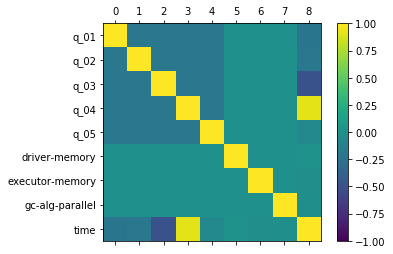

In [5]:
correlations = all_df.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(df.columns)
plt.show()

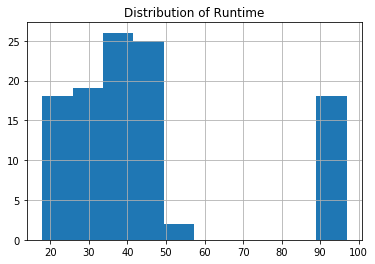

In [6]:
all_df.time.hist()
plt.title("Distribution of Runtime")
plt.show()

In [7]:
all_df.loc[all_df.time > 80] # all query #4!!!

,q_01,q_02,q_03,q_04,q_05,driver-memory,executor-memory,gc-alg-parallel,time
16,0,0,0,1,0,4,3,0,94.571
27,0,0,0,1,0,2,4,1,90.965
29,0,0,0,1,0,3,3,0,90.358
32,0,0,0,1,0,4,4,0,92.570
39,0,0,0,1,0,2,3,0,90.456
40,0,0,0,1,0,4,3,1,93.313
47,0,0,0,1,0,3,4,1,94.213
50,0,0,0,1,0,3,4,0,93.826
53,0,0,0,1,0,3,3,1,92.468
55,0,0,0,1,0,4,4,1,91.565


Standardizing y (time) does not help. Going to remove query 4.

In [43]:
df_no4 = all_df.loc[all_df.q_04 == 0]
df_no4 = df_no4.drop("q_04", axis=1)
df_no4.head()

,q_01,q_02,q_03,q_05,driver-memory,executor-memory,gc-alg-parallel,time
0,0,1,0,0,3,2,1,34.645
1,0,0,0,1,2,2,1,40.037
2,1,0,0,0,2,4,1,32.401
3,0,0,0,1,4,4,1,40.747
4,0,1,0,0,3,4,0,34.123


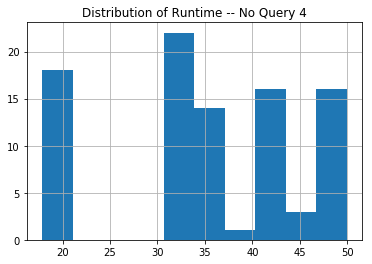

In [9]:
df_no4.time.hist()
plt.title("Distribution of Runtime -- No Query 4")
plt.show()

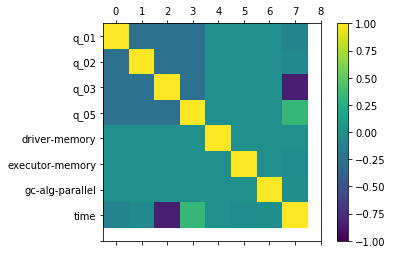

In [44]:
correlations = df_no4.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(df_no4.columns)
plt.show()

In [17]:
temp_y = df_no4.time.values.reshape(len(df_no4), 1)

In [29]:
# https://www.isixsigma.com/tools-templates/normality/making-data-normal-using-box-cox-power-transformation/
bc = preprocessing.PowerTransformer(method='box-cox', standardize=True) # NOTE! only works with sklearn 0.2+
bc_y = bc.fit_transform(temp_y)
print(bc.lambdas_)

[1.48675737]


TODO: Need to interpret box-cox differently

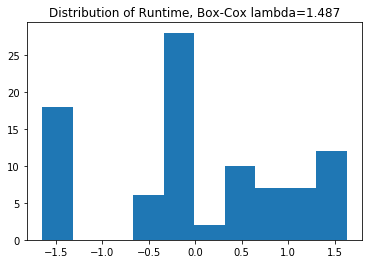

In [30]:
plt.hist(bc_y)

plt.title("Distribution of Runtime, Box-Cox lambda=1.487")
plt.show()

[-0.22718352]


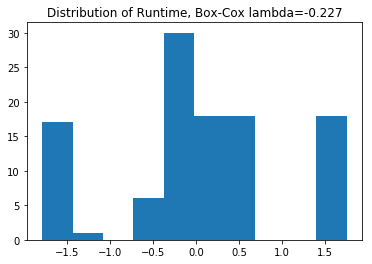

In [74]:
bc_y2 = bc.fit_transform(all_df.time.values.reshape(len(all_df), 1))
print(bc.lambdas_)

plt.hist(bc_y2)
plt.title("Distribution of Runtime, Box-Cox lambda=-0.227")
plt.show()

#### Split Train and Test

In [35]:
df = df_no4
df['bc_time'] = bc_y

In [47]:
rs = np.random.RandomState(seed=1)

In [50]:
X = df.iloc[:,:-2]
y = df['bc_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rs) # 80/20 split!

## Linear Regression

In [52]:
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X, y))
y_pred_reg = reg.predict(X_test)
mean_squared_error(y_test, y_pred_reg)

0.9914113334493718


0.0071280741821236

In [71]:
c = pd.DataFrame(reg.coef_)
c = c.T
c.columns = X_train.columns
c

,q_01,q_02,q_03,q_05,driver-memory,executor-memory,gc-alg-parallel
0,-1.6999,-1.583785,-2.973659,-0.780991,0.038553,-0.026146,-0.019481


## LASSO

In [61]:
lasso = Lasso(random_state=rs).fit(X_train, y_train)
print(lasso.score(X_train, y_train))
print(lasso.coef_)

0.0
[-0. -0. -0.  0. -0.  0. -0.]


In [62]:
y_pred_lasso = lasso.predict(X_test)
mean_squared_error(y_test, y_pred_lasso)

1.2091106563963285

In [ ]:
# if we want to use it as a feature selector
model = SelectFromModel(lasso, prefit=True)
lasso_X = model.transform(X_)

new_labels = []
features = X_df.columns

for i, feature in zip(model.get_support(), features): # get headers, since they get lost after lasso
    if i:
        new_labels.append(feature)

lasso_df = pd.DataFrame(lasso_X, columns=features)
lasso_df['time'] = y_series

## Random Forest

In [67]:
# use original Y
X = df.iloc[:,:-2]
y = df['time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rs) # 80/20 split!

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
rf = RandomForestRegressor(random_state=rs)
rf.fit(X_train, y_train)

s = pd.DataFrame((rf.feature_importances_))
s = s.T
s.columns = X_train.columns

s

C:\Users\Cindy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,q_01,q_02,q_03,q_05,driver-memory,executor-memory,gc-alg-parallel
0,0.092748,0.154192,0.706102,0.038577,0.003731,0.002993,0.001657


In [69]:
y_pred_rf = rf.predict(X_test)
mean_squared_error(y_test, y_pred_rf)

1.49769945833333

----------------
### Including q4

In [76]:
df2 = all_df
df2['bc_time'] = bc_y2

X = df2.iloc[:,:-2]
y = df2['bc_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rs) # 80/20 split!

C:\Users\Cindy\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [77]:
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X, y))
y_pred_reg = reg.predict(X_test)
mean_squared_error(y_test, y_pred_reg)

0.9965241486237922


0.007548282534325843

In [78]:
c = pd.DataFrame(reg.coef_)
c = c.T
c.columns = X_train.columns
c

,q_01,q_02,q_03,q_04,q_05,driver-memory,executor-memory,gc-alg-parallel
0,-0.785468,-0.699399,-2.129438,1.230937,-0.283089,0.022969,-0.012135,-0.004231


## LASSO

In [79]:
lasso = Lasso(random_state=rs).fit(X_train, y_train)
print(lasso.score(X_train, y_train))
print(lasso.coef_)

0.0
[-0. -0. -0.  0.  0.  0.  0. -0.]


In [80]:
y_pred_lasso = lasso.predict(X_test)
mean_squared_error(y_test, y_pred_lasso)

1.032066401852373

## Random Forest

In [84]:
# use original Y
X = df2.iloc[:,:-2]
y = df2['time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rs) # 80/20 split!

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
rf = RandomForestRegressor(random_state=rs)
rf.fit(X_train, y_train)

s = pd.DataFrame((rf.feature_importances_))
s = s.T
s.columns = X_train.columns

s

C:\Users\Cindy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,q_01,q_02,q_03,q_04,q_05,driver-memory,executor-memory,gc-alg-parallel
0,0.017605,0.023838,0.120955,0.827703,0.007151,0.001425,0.000966,0.000358


In [85]:
y_pred_rf = rf.predict(X_test)
mean_squared_error(y_test, y_pred_rf)

2.0969856677272714